<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/ImageClass/CatRabbitSqrll/modelTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch ile Kendi Datasetinden Eğitim


Bir çok tutorialda torchvision dataset içinden hızlıca bir dataset çekmek tercih edilir çünkü çok kolayca düzgün bir dataset oluşturmuş olursun.

Biz bugün kendi elimizdeki bir data seti kullanarak bu işlemleri yapacağız.

Bunun için bir bulk downloader uzantısı ile googledan bir çok resmi hızlıca kayıt edebilir ya da elimizdeki hazır bir seti kullanabiliriz. Araştırmalar sırasında video çekip bu videodan bir python scripti ile ekran görüntüleri almak gibi teknikler ile de veri setleri hızlıca oluşturulabilir

ancak data bir miktar düzenlemeye ihtiyaç duyabilir.



# Database yapısı


Oldukça basit bir yapıyı takip edeceğiz
                                      
data/                                           
├─ cat/             
│  ├─ image001.jpg             
│  ├─ image002.jpg             
│  ├─ ....             
├─ rabbit/             
│  ├─ image001.jpg             
│  ├─ image002.jpg             
│  ├─ ....      
├─ squirrel/             
│  ├─ image001.jpg             
│  ├─ image002.jpg             
│  ├─ ....         

Bu dosya hem zipli hem de sıkıştırılmamış olarak repoda mevcut. Zipli hali colabda çalışırken wget ile kolayca indirmen için

Colabde isen kolayca indir

In [2]:
!wget https://github.com/onuralpArsln/MlAiTutorialProjects/raw/main/ImageClass/CatRabbitSqrll/data.zip

--2024-07-18 09:30:45--  https://github.com/onuralpArsln/MlAiTutorialProjects/raw/main/ImageClass/CatRabbitSqrll/data.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/main/ImageClass/CatRabbitSqrll/data.zip [following]
--2024-07-18 09:30:45--  https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/main/ImageClass/CatRabbitSqrll/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76061926 (73M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  72.54M  85.2MB/s    in 0.9s    

2024-07-18 09:30:50 (85.2 

In [3]:
!unzip -q data.zip

# Define Transforms

Transfromların olay resimlere rastgele değişimler uygulamaktır.  

Bu hem elimizdeki data miktarını arttırmak için güzel bir metot hem de farklı koşullar altında da tanıma yapabilmek için önemli.

Örneğin rastgele döndürmeler eklemek sayesinde eğer kedi baş aşağı durursa da onu tanıyacağız.





In [4]:
import torchvision.transforms as transforms

In [38]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5)
])

Bu transformlar  oldukça önemli. Oncelikle resim boytlarımızı sabit bir şekilde almak sistemin çalışması için önemli. Girdilerimiz sabit bir boyuta aldık.
resimleri tensore çevirerek sistem tarafından anlaşılır bir hale getirdik. Rastgele dönmeler eklemek ise farklı koşullar altında tanımayı kolaylaştırır.

# Data setimizi aktarmak

Bu noktada bizim data setimiz düzenli olduğu için bir metot kullanacağız ancak düzensiz bir data setin var ise nasıl çalışman gerektiğinin örneğide olacak


Ayrıca bizim data setimizde iki sınıf içinde yakın miktarda görsel var. Bu iyi bir dataset için önemli bir yapıdır.

In [6]:
import torchvision
from torchvision.datasets import ImageFolder

In [39]:
dataset = torchvision.datasets.ImageFolder(root='data', transform=transform)

# Custom Dataset

Eğer dataset dosya yapın bizim örnekteki gibi düzenli değil ise  aşağıdaki methodu uygulayacaksın. Ama düzenli bir datasetine sahip olmak her zaman daha iyidir.

__init__(), __len__(), ve __get_item__() methodlarını tanımlamak zorundasın sistemin çalışması için

In [28]:
import glob
import os
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
#glob ve os sistem dizin kontrolü için


class CustomDataset(Dataset):
    # transform ve dosya adresi bilgilerini alarak objeyi başlatır.
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.image_paths = []
        # tercih edilen dosya uzantılarını buraya yaz bizde sadece png ve jpeg mevcut
        for ext in ['png', 'jpg']:
            self.image_paths += glob.glob(os.path.join(root_dir, '*', f'*.{ext}'))
        # set oluşturmak her dizine sadece bir kere uğramak için
        class_set = set()
        # mevcut olan her resim adresini ekle
        for path in self.image_paths:
            class_set.add(os.path.dirname(path))
        self.class_lbl = { cls: i for i, cls in enumerate(sorted(list(class_set)))}
    #  veri  setinin boyutunu döndürebilmek için bir method
    def __len__(self):
        return len(self.image_paths)
    # idx indexideki veriyi yükler
    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx], ImageReadMode.RGB).float()
        cls = os.path.basename(os.path.dirname(self.image_paths[idx]))
        label = self.class_lbl[cls]
        # label bilgisinide paylaşır
        return self.transform(img), torch.tensor(label)

In [31]:
custom_dataset = CustomDataset('data/', transform)

# Split Data


Amacımız test, validation  ve train oluşturmak.

train-> eğitim için kullanılcak veri

validation -> eğitim sırasında parametre optimizasyonu için kullanılan veri kısmı

test-> model eğitildikten sonra performans ölçümü için kullanılır.

In [8]:
splits = [0.8, 0.1, 0.1]

In [9]:
split_sizes = []
for sp in splits[:-1]:
    split_sizes.append(int(sp * len(dataset)))
split_sizes.append(len(dataset) - sum(split_sizes))

In [43]:
import torch
import torch.utils
train_set, test_set, val_set = torch.utils.data.random_split(dataset, split_sizes)

In [11]:
train_set, test_set, val_set = torch.utils.data.random_split(dataset, split_sizes)

In [12]:
val_set.transform = test_set.transform = transforms.Compose([
    transforms.Resize((128, 128))
])

# DataLoader

Dataloader pytorch içinde iterasyona izin veren bir yapıdır. böylece verilerini pytorch içinde kullanılacak bir yapıya çevirirsin.

In [13]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [44]:
dataloaders = {
    "train": DataLoader(train_set, batch_size=16, shuffle=True),
    "test": DataLoader(test_set, batch_size=16, shuffle=False),
    "val": DataLoader(val_set, batch_size=16, shuffle=False)
}

# Define the Classifier

Sınıflandırmayı yapan modele classifier denir.

her nöral yapı gibi classifier de katmanlardan oluşur. bu katmanları istersek kendimiz elle belirleyebiliriz. Ancak uzmanların hazırladığı güçlü yapılarda pytorch içinden kolayca ulaşılabilir.  Bu tutorialde amacımız öğrenmek olduğu için nasıl yapılıyor göreceğiz ama bir mühendislik uygulaması sırasında iyi ve hazır bir nöral yapıyı kullanmak iyi fikirdir.

## Custom Architecture

aşağıda iki farklı yapı var. eğer ikiden çok çıkışın / sınıfın varsa çok sayıda nöron gerekir

1 0 0      kedi       
0 1 0      tavşan                        
0 0 1      sincap                    
gibi            

ancak eğer iki  çıkış lazımsa            
1 kuş             
0 tavşan                   

yapabilirsin.


In [ ]:
## Çok sınıflı sınıflandırma için


class CustomModel(torch.nn.Module):   ## custom model yapmak için miras alınıyor
    def __init__(self):
        super(CustomModel, self).__init__() ## miras alınan parentin init çalışıyor

        # linear ( fully connected) bir giriş 128 boyutlu girdi alıyor ve
        #256 boyutunda bir tensor dışarı veriyor
        self.linear1 = torch.nn.Linear(128, 256)

        # ReLu Rectified Linear Unit aktivasyonu ilk layerdan sonra kullanılıyor
        self.activation = torch.nn.ReLU()

        # aşağıdaki 3 sayısı 3 sınıf olduğu için 4 olsa 4 yazardık
        # iki katman var giriş ve çıkış 128 girdi 3 çıktı
        self.linear2 = torch.nn.Linear(256, 3)

        # soft max katmanı çıktıyı olasılığa dönüştürür.
        # softmax çok sınıflı sınıflandırma için daha uygundur.
        self.softmax = torch.nn.Softmax()

  # ileri yönde modelde harekti yapıyoruz
  # x datasını katmanlardan geçiriyor ve sonucu döndürüyor
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

In [ ]:
## Binary ikili sınıflandırma içi
class CustomModel(torch.nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        self.linear1 = torch.nn.Linear(128, 256)
        self.activation = torch.nn.ReLU()
        # çıktı tek boyutlu yani bu binary sınıflandırma
        self.linear2 = torch.nn.Linear(256, 1)
        # sigmoid aktivasyon ikili sınıflandırma için daha uygundur.
        self.softmax = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

## Import Model Architecture from pytroch

Modelleri tasarlamak uzmanlık isteyen bir iştir. İleri seviye çalışmalarda işlerimize özel uygulamalar için bunu yapmak zorunda kalabiliriz. Ancak hali hazırda optimize modelleri kendi amacımza uygun olarak editleyip kullanmakta oldukça makul bir fikir.

Model eğitimin en önemli noktalarından biride noron ağırlıklarının hesaplanması.

hali hazırda eğitilmiş Resneti alıp üzerinde biraz çalışalım.

In [15]:
from torchvision.models import resnet50, ResNet50_Weights

resnet50 modelini ve resnet50 için eğitim ağırlıklarını aldık.

In [17]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 63.0MB/s]


ResNet50 ağırlıkları ile modeli aktive ettik.

In [18]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 3)
)

Model.fc full connected demektir.  
torch.nn.sequential ise bilginin sırayla tüm ağ katmanlarından geçtiğini anlatır.   

torch.nn.Linear(2048, 256)  ilk linear katmanda 2048lik giriş ve 256lık çıkış olacak

torch.nn.ReLU(): ReLU aktivasyon fonksiyonu, ardından gelen lineer katmanın çıktısını alır. Bu, non-lineerlik ekler ve modelin daha karmaşık ilişkileri öğrenmesine yardımcı olur.


torch.nn.Linear(256, 3): bu ise çıkış katmanı olan ikinci katmanı düzenler. Normalde resnet50, 1000 çıkışa sahiptir ancak biz 3 sınıflık çıktı istiyoruz. eğer 4 sınıf istiyorsan bu sayıyı 4 yapmalısın.


Bu kod parçası, resnet50 modelinin sonundaki fully connected katmanları değiştirerek, modelin çıkışını 3 farklı sınıfa (veya sınıf sayısına) uyacak şekilde özelleştiriyor. Bu tür bir yapılandırma genellikle transfer learning veya özel veri kümesine özgü uygulamalar için kullanılır, mevcut ağın özellik çıkarma yeteneklerini koruyarak sadece sınıflandırma kısmını değiştirir.

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Modeli cuda ya da cpu için uyumlu olarak ayarlıyoruz.

# Parametreleri dondurmak

Eğitim sırasında belli katman ve ağırlıkları sabit tutmak manasına gelen bir uygulamadır.

Bizim şuan yaptığımız gibi bir transfer learnin yapıyorsan yani önceden eğitilmiş bir model ve ağırlıklarını alıp kendi ihtiyacın için düzenliyorsan parametre dondurmak işe yarayabilir.

Eğitimi hızlandırır ve eski ağırlıkları korumak overfitting reiskini azaltır.

Biz eski parametreleri dondururken yeni gelenleri eğitmek istiyoruz.


In [ ]:
# önceden eğitilmiş networke ait parametreleri dondur
for param in model.parameters():
    param.requires_grad = False

# yeni eklenen ve değişenleri ise eğit.
for param in model.fc.parameters():
    param.requires_grad = True


requires_grad  eğer doğru ise gradient bu tensor için hesaplanır değilse hesaplanmaz

# Define the Loss Function and the Optimizer

Loss Function -> modelin tahmini ile gerçek sonucun birbirinden uzaklığınız ifade eder.

Optimizer -> Loss foksyionunu en azaa indigirmek için yapılan çalışmadır. İki örnek olarak ;

Gradient Descent -> loss fonksiyonunun gradientini (eğimin yönünü) kullanarak parametreleri günceller. Loss fonksiyonunu büyük 3 boyutlu  bir grafik olarak düşün.

Adam (Adaptive Moment Estimation) ->  adaptif öğrenme oranları ve momentum kullanarak gradient descent'in daha hızlı çalışmasını sağlar.

In [20]:
criterion = torch.nn.CrossEntropyLoss()

In [22]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=0.0001)

model.parameters() model ağırlıklarını, lr ise learning ratei optimizera aktarır.

learning rate -> parametrelerin güncellenme hızını belirler. küçük değerler yavaş yavaş ggüncellenmeye sebp olur. Bu yerel minimumlara takılma riskini oluşturur ve süreyi uzatabilir.
yüksek rateler ise  model hatasını arttırabilir ama hızlıca eğitimin tamamlanmasınada sebep olabilir.

# Training Model

In [23]:
metrics = {
    'train': {
         'loss': [], 'accuracy': []
    },
    'val': {
         'loss': [], 'accuracy': []
    },
}

eğitim sırasında olanları loglamak için bir sözlük oluştuırduk.

In [45]:


## 30 epoch atacağımız için range30
for epoch in range(30):
  ## epoch datasını loglamak için
  ep_metrics = {
    'train': {'loss': 0, 'accuracy': 0, 'count': 0},
    'val': {'loss': 0, 'accuracy': 0, 'count': 0},
  }

  print(f'Epoch {epoch}')

  ##  her epochta train ve valiadation var
  for phase in ['train', 'val']:
    print(f'-------- {phase} --------')

    # data loaderdan datayı al ve üzerinde gez
    for images, labels in dataloaders[phase]:
      #graidenti her tur sıfırlıyoruz yoksa graidentler birikir
      optimizer.zero_grad()

      # görselleri modelden geçirdik
      with torch.set_grad_enabled(phase == 'train'):
        output = model(images.to(device))
        # labelları one hot encode yapık (0 0 1  / 1 0 0 / 0 1 0)
        ohe_label = torch.nn.functional.one_hot(labels, num_classes=3)

        # sonuçla gerçeği kıyasla ve lossu bull
        loss = criterion(output, ohe_label.float().to(device))
        # argmax ile accuracy hesapla
        correct_preds = labels.to(device) == torch.argmax(output, dim=1)
        accuracy = (correct_preds).sum()/len(labels)

      if phase == 'train':
        # loss üzerinde backpropagete yap ve gradient hesapla
        loss.backward()
        # ağırlıkları güncelle
        optimizer.step()

      # metrikleri takip eder
      ep_metrics[phase]['loss'] += loss.item()
      ep_metrics[phase]['accuracy'] += accuracy.item()
      ep_metrics[phase]['count'] += 1


    ep_loss = ep_metrics[phase]['loss']/ep_metrics[phase]['count']
    ep_accuracy = ep_metrics[phase]['accuracy']/ep_metrics[phase]['count']

    print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')

    metrics[phase]['loss'].append(ep_loss)
    metrics[phase]['accuracy'].append(ep_accuracy)

Epoch 0
-------- train --------
Loss: 0.726664662361145, Accuracy: 0.6861979179084301

-------- val --------
Loss: 0.6360697249571482, Accuracy: 0.6041666666666666

Epoch 1
-------- train --------
Loss: 0.19137765932828188, Accuracy: 0.9518229179084301

-------- val --------
Loss: 0.5441703945398331, Accuracy: 0.6458333333333334

Epoch 2
-------- train --------
Loss: 0.06165928166592494, Accuracy: 0.984375

-------- val --------
Loss: 0.5201831708351771, Accuracy: 0.8958333333333334

Epoch 3
-------- train --------
Loss: 0.07003036618698388, Accuracy: 0.9830729179084301

-------- val --------
Loss: 0.6040978928407034, Accuracy: 0.5625

Epoch 4
-------- train --------
Loss: 0.11002121662022546, Accuracy: 0.9557291679084301

-------- val --------
Loss: 0.6261329352855682, Accuracy: 0.5833333333333334

Epoch 5
-------- train --------
Loss: 0.041242501145461574, Accuracy: 0.9921875

-------- val --------
Loss: 0.4883938630421956, Accuracy: 0.9166666666666666

Epoch 6
-------- train -------

# Visualize the metrics


Görselleştirme sıkıcı yazılardan çok daha iyidir.

In [46]:
import matplotlib.pyplot as plt

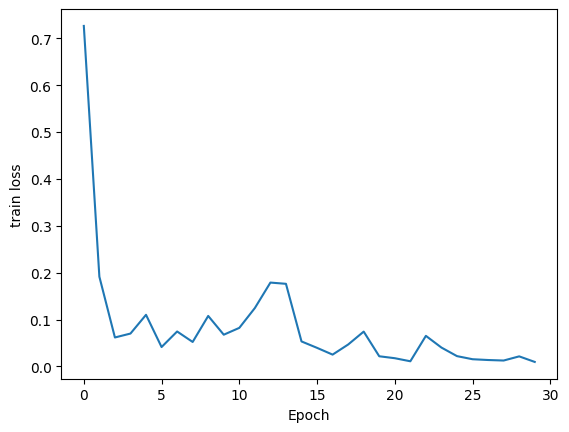

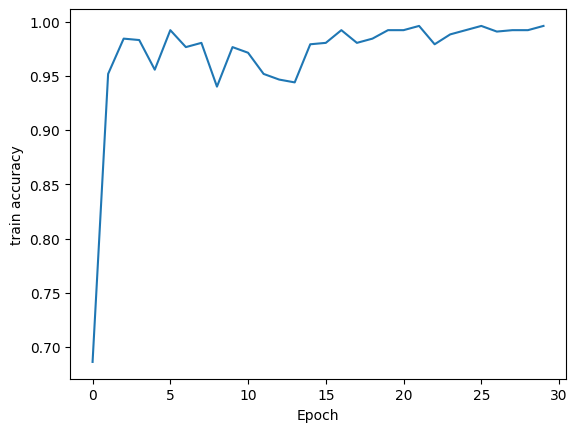

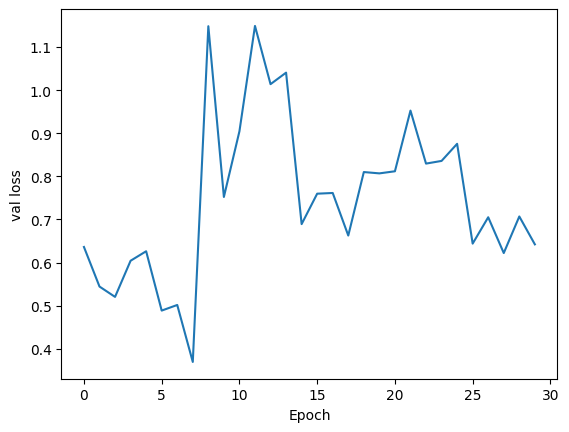

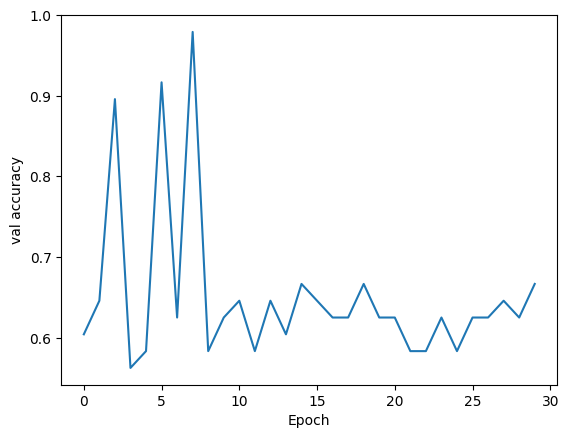

In [47]:
for phase in metrics:
    for metric in metrics[phase]:
        metric_data = metrics[phase][metric]
        plt.plot(range(len(metric_data)), metric_data)
        plt.xlabel('Epoch')
        plt.ylabel(f'{phase} {metric}')
        plt.show()

 Testing the classifier model

In [49]:
!pip install tqdm

# Testing Model

In [52]:
from tqdm import tqdm
preds = []
actual = []

tot_loss = tot_acc = count = 0

for images, labels in tqdm(dataloaders['test']):
    with torch.set_grad_enabled(False):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels, num_classes=3)
        out_labels = torch.argmax(output, dim=1)


        tot_loss += criterion(output, ohe_label.float().to(device))
        tot_acc += (labels.to(device) == out_labels).sum()/len(labels)
        count += 1

    preds += out_labels.tolist()
    actual += labels.tolist()

print(f"Test Loss: {tot_loss / count}, Test Accuracy: {tot_acc / count}")

100%|██████████| 2/2 [00:03<00:00,  1.57s/it]

Test Loss: 0.15790076553821564, Test Accuracy: 0.9041666984558105


Yüzde doksan isabet

# Modeli Kaydetmek


In [63]:
# Specify path to save to
PATH = "resnet_modified.pth"

# Save the model state dictionary
torch.save(model.state_dict(), PATH)

# Modeli kullanmak

In [67]:
import torch
from torchvision import models

# Define your modified ResNet model with custom classifier
class ModifiedResNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        # Replace the fully connected layer (classifier) with your custom structure
        self.resnet.fc = torch.nn.Sequential(
            torch.nn.Linear(2048, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# Initialize the model
model = ModifiedResNet(num_classes=3)  # Adjust num_classes based on your problem

# Load the model state_dict, adjusting keys to match the current model structure
state_dict = torch.load('resnet_modified.pth')
new_state_dict = {}
for key, value in state_dict.items():
    new_key = 'resnet.' + key
    new_state_dict[new_key] = value

model.load_state_dict(new_state_dict)

# Set the model to evaluation mode
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ModifiedResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    